In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.stats import gaussian_kde

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import random
import gc 

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 300
pd.options.display.max_columns = 1000

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
            for stat in ['count', 'count_norm']:
                column_names.append('%s_%s_%s' % (df_name, var, stat))
    categorical.columns = column_names
    return categorical

def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

def agg_numeric(df, parent_var, df_name):
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    columns = []

    for var in agg.columns.levels[0]:
        if var != parent_var:
            for stat in agg.columns.levels[1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
def remove_missing_columns(train, test, threshold = 90):
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    return train, test

def agg_categorical(df, parent_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))

    categorical[parent_var] = df[parent_var]

    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['sum', 'count', 'mean']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    # e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    
    feat = pd.concat([a, b, c, d]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)[["Feature_fold1",'Importance_fold1']]
    plt.figure(figsize=(10,14))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices.iloc[:50, 0])
    return indices

import sys

# データが何GBかを指す
def return_size(df):
    return round(sys.getsizeof(df) / 1e9, 2)

# データを軽くする
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    for c in df:
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)       
    new_memory = df.memory_usage().sum()
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')   
        print(df.shape)
    return df

def num_cat(df):
    num_f = df.dtypes[df.dtypes != 'object'].index
    cat_f = df.dtypes[df.dtypes == 'object'].index
    return num_f, cat_f

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

sampler = RandomUnderSampler(random_state=42)
def predict_cv(model, train_x, train_y, test_x, esr):
    preds = []
    preds_test = []
    va_indexes = []
    train_score = []
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6785)
    
    feature_importance_df = pd.DataFrame()
    col = list(train_x.columns)
    i = 1
    feat_df = pd.DataFrame()
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=1000, 
                  early_stopping_rounds=esr)
        
        
        tr_pred = model.predict_proba(tr_x)[:, 1]
        pred = model.predict_proba(va_x)[:, 1]
        preds.append(pred)
        pred_test = model.predict_proba(test_x)[:, 1]
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        
        fold_feat_df = pd.DataFrame()
        fold_feat_df["Feature_fold{}".format(i)] = col
        fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
        i += 1
        feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
        print('  score Train : {:.6f}' .format(roc_auc_score(tr_y, tr_pred)), 
              '  score Valid : {:.6f}' .format(roc_auc_score(va_y, pred)))
        train_score.append(roc_auc_score(tr_y, tr_pred))
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('*'*40)
    print('train Score : {:.6f}' .format(np.mean(train_score)))
    print('valid Score : {:.6f}' .format(roc_auc_score(train_y, pred_train)))
    print('train Score - valid Score : {:.6f}'.format(np.mean(train_score) - roc_auc_score(train_y, pred_train)))
    return pred_train, preds_test, model, feat_df

import re
def rename_data(df):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return df


In [3]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Table', 'Description','日本語訳']]

# ラグ特徴量を入れたデータをtrain, testとして読み込む

In [4]:
train = pd.read_pickle('../home credit/all_table_lag_train_df.pkl')
test = pd.read_pickle('../home credit/all_table_lag_test_df.pkl')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 202 entries, client_installments_AMT_PAYMENT_min_max to TARGET
dtypes: float16(58), float32(76), float64(55), int16(2), int32(8), int8(3)
memory usage: 266.0 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 0 to 48743
Columns: 201 entries, client_installments_AMT_PAYMENT_min_max to SK_ID_CURR
dtypes: float16(58), float32(76), float64(55), int16(2), int32(8), int8(2)
memory usage: 42.1 MB


# そもそも現時点でどんな特徴量があるのか？

In [7]:
train

,client_installments_AMT_PAYMENT_min_max,client025_cash025_entryinstallment_mean_mean,previous3_DAYS_LAST_DUE_1ST_VERSION_min,client10_cash10_AMT_INSTALMENT_mean_min,client5_cash5_AMT_PAYMENT_min_mean,bureau_AMT_CREDIT_SUM_DEBT_mean,NEW_PHONE_TO_BIRTH_RATIO,client025_cash025_AMT_RECEIVABLE_PRINCIPAL_min_max,previous5_NAME_CONTRACT_STATUS_Refused_mean,client5_cash5_entryinstallment_mean_mean,NEW_CAR_TO_EMPLOY_RATIO,client3_cash3_SK_DPD_mean_mean_x,appAMT_INCOME_TOTAL12AMT_ANNUITY,previous_AMT_DOWN_PAYMENT_mean,bureau_CREDIT_TYPE_Microloan_count_norm,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_installments_AMT_PAYMENT_mean_max,client025_cash025_CNT_INSTALMENT_FUTURE_min_mean,DEF_30_CNT_SOCIAL_CIRCLE,bureau_AMT_CREDIT_SUM_mean,previous5_NAME_YIELD_GROUP_low_action_mean,AMT_REQ_CREDIT_BUREAU_QRT,client025_cash025_AMT_BALANCE_min_sum,client1_cash1_CNT_DRAWINGS_ATM_CURRENT_sum_max,client05_cash05_CNT_INSTALMENT_FUTURE_max_mean,previous_HOUR_APPR_PROCESS_START_max,OWN_CAR_AGE,client025_cash025_AMT_PAYMENT_min_min,client5_cash5_DAYS_ENTRY_PAYMENT_mean_mean,client1_cash1_CNT_DRAWINGS_ATM_CURRENT_mean_sum,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_INSTALMENT_min_sum,client1_cash1_AMT_PAYMENT_min_sum,client05_cash05_CNT_INSTALMENT_FUTURE_max_max,client025_cash025_AMT_PAYMENT_min_max,client025_cash025_AMT_PAYMENT_mean_max,previous_HOUR_APPR_PROCESS_START_mean,REGION_RATING_CLIENT,client5_cash5_CNT_INSTALMENT_FUTURE_min_mean,previous10_CNT_PAYMENT_mean,client5_cash5_AMT_INSTALMENT_min_sum,client3_cash3_AMT_PAYMENT_min_min,client3_cash3_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_mean,client10_cash10_AMT_PAYMENT_min_sum,bureau_AMT_CREDIT_SUM_LIMIT_mean,client1_cash1_AMT_INSTALMENT_max_max,previous_NAME_YIELD_GROUP_low_action_mean,NAME_EDUCATION_TYPE,client_cash_MONTHS_BALANCE_mean_min,previous3_AMT_ANNUITY_min,previous_NAME_YIELD_GROUP_low_normal_mean,client_installments_AMT_PAYMENT_max_sum,previous_NAME_CONTRACT_STATUS_Approved_mean,client3_cash3_CNT_INSTALMENT_FUTURE_mean_max,client5_cash5_entryinstallment_mean_max,client10_cash10_entryinstallment_mean_max,client1_cash1_SK_DPD_DEF_max_sum_x,client3_cash3_CNT_DRAWINGS_CURRENT_max_max,appAMT_INCOME_TOTALAMT_ANNUITY,client025_cash025_AMT_INSTALMENT_min_min,client_bureau_balance_STATUS_0_count_max,client3_cash3_SK_DPD_DEF_mean_max_x,client_installments_AMT_PAYMENT_min_mean,client5_cash5_CNT_DRAWINGS_CURRENT_max_max,client3_cash3_CNT_DRAWINGS_ATM_CURRENT_mean_max,bureau_AMT_CREDIT_SUM_min,client05_cash05_AMT_PAYMENT_min_min,NAME_FAMILY_STATUS,CODE_GENDER,client1_cash1_CNT_INSTALMENT_FUTURE_max_mean,bureau_CREDIT_ACTIVE_Closed_count_norm,previous1_NAME_CONTRACT_STATUS_Refused_mean,previous3_NAME_CONTRACT_STATUS_Refused_mean,client3_cash3_entryinstallment_mean_mean,previous_NAME_CONTRACT_STATUS_Refused_mean,client10_cash10_entryinstallment_min_sum,REG_CITY_NOT_LIVE_CITY,client_installments_AMT_PAYMENT_mean_sum,client1_cash1_SK_DPD_DEF_mean_mean_x,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_DAYS_CREDIT_ENDDATE_max,bureau_CREDIT_TYPE_Mortgage_count_norm,NAME_INCOME_TYPE,bureau_AMT_CREDIT_MAX_OVERDUE_mean,client1_cash1_SK_DPD_mean_min_x,previous1_DAYS_LAST_DUE_1ST_VERSION_min,DAYS_ID_PUBLISH,client5_cash5_CNT_DRAWINGS_CURRENT_max_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_mean,previous_AMT_DOWN_PAYMENT_sum,EXT_SOURCE_1,NEW_ANNUITY_TO_INCOME_RATIO,NAME_CONTRACT_TYPE,bureau_AMT_CREDIT_SUM_DEBT_max,previous3_DAYS_LAST_DUE_1ST_VERSION_sum,client1_cash1_NUM_INSTALMENT_VERSION_max_max,client025_cash025_AMT_INSTALMENT_min_sum,previous_DAYS_LAST_DUE_1ST_VERSION_sum,DAYS_BIRTH,previous_CODE_REJECT_REASON_XAP_mean,EXT_SOURCE_3,previous3_CNT_PAYMENT_mean,previous3_NAME_YIELD_GROUP_high_sum,client3_cash3_entryinstallment_mean_min,client3_cash3_SK_DPD_max_mean_x,client10_cash10_NUM_INSTALMENT_VERSION_mean_sum,client5_cash5_CNT_DRAWINGS_ATM_CURRENT_mean_max,client05_cash05_CNT_INSTALMENT_FUTURE_min_mean,client5_cash5_AMT_PAYMENT_mean_min,NEW_DOC_IND_K

In [8]:
search_description('AMT_RECEIVABLE_PRINCIPAL')

,Table,Description,日本語訳
165,credit_card_balance.csv,Amount receivable for principal on the previous credit,以前のクレジットの元本の金額の受取


# discussionにあったやつ

### application_train['CREDIT/ANUITY']

In [9]:
application_train['CREDIT/ANNUITY'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']
application_test['CREDIT/ANNUITY'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY']
train = train.merge(application_train[['CREDIT/ANNUITY', 'SK_ID_CURR']], on = 'SK_ID_CURR', how='left')
test = test.merge(application_test[['CREDIT/ANNUITY', 'SK_ID_CURR']], on = 'SK_ID_CURR', how='left')

### REGION_POPULATION_RELATIVEをカテゴリ変数にしたものが効くらしい

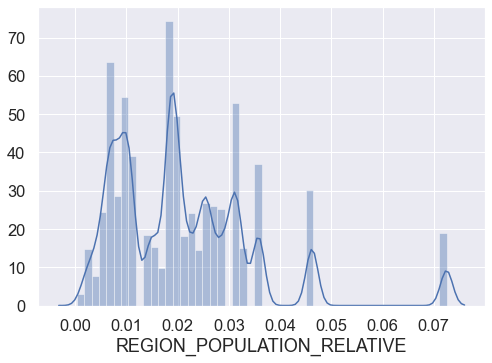

In [10]:
sns.distplot(application_train['REGION_POPULATION_RELATIVE'])

In [11]:
search_description('REGION_POPULATION_RELATIVE')

,Table,Description,日本語訳
19,application_{train|test}.csv,Normalized population of region where client lives (higher number means the client lives in more populated region),地域の正規化された人口クライアント命（高い数はより多くの人口地域のクライアントの生活を意味します）


In [12]:
application_train['region_id'] = pd.cut(application_train['REGION_POPULATION_RELATIVE'], 4, labels=['a', 'b','c','d'])
application_test['region_id'] = pd.cut(application_test['REGION_POPULATION_RELATIVE'], 4, labels=['a', 'b','c','d'])

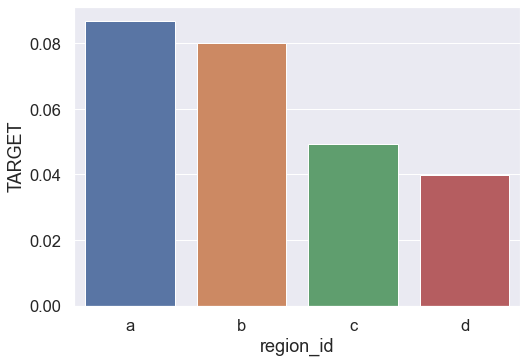

In [13]:
group = application_train.groupby('region_id').agg({'TARGET': 'mean'}).reset_index()
sns.barplot(x='region_id', y='TARGET', data=group)

In [14]:
search_description('AMT_CREDIT_SUM_DEBT')

,Table,Description,日本語訳
136,bureau.csv,Current debt on Credit Bureau credit,クレジットビューローの信用上の現在の債務


In [15]:
train = train.merge(application_train[['SK_ID_CURR', 'region_id']], on='SK_ID_CURR', how='left')
test = test.merge(application_test[['SK_ID_CURR', 'region_id']], on='SK_ID_CURR', how='left')

In [16]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

### AMT_CREDIT_SUM_DEBTの合計がAM_CREDIT_SUMの合計を上回っている

In [17]:
bureau = pd.read_pickle('../home credit/bureau.pickle')

In [18]:
bureau['AMT_CREDIT_SUM_DEBT']

0               0.0
1          171342.0
2               NaN
3               NaN
4               NaN
             ...   
1716423     11250.0
1716424         0.0
1716425         NaN
1716426         0.0
1716427         0.0
Name: AMT_CREDIT_SUM_DEBT, Length: 1716428, dtype: float32

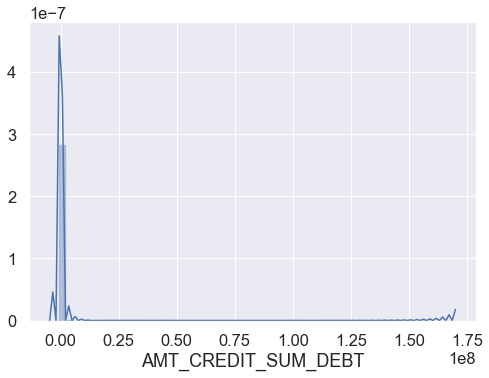

In [22]:
sns.distplot(bureau['AMT_CREDIT_SUM_DEBT'])

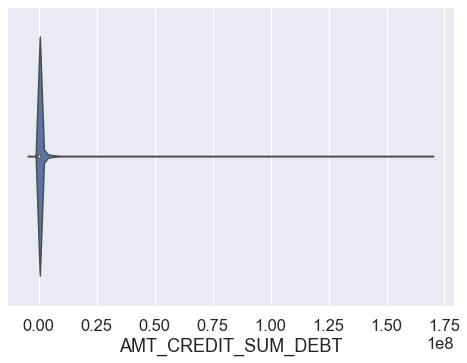

In [23]:
sns.violinplot(bureau['AMT_CREDIT_SUM_DEBT'])

In [24]:
bureau['AMT_CREDIT_SUM_DEBT'].isnull().value_counts()

False    1458759
True      257669
Name: AMT_CREDIT_SUM_DEBT, dtype: int64

In [25]:
search_description('AMT_CREDIT_SUM')

,Table,Description,日本語訳
135,bureau.csv,Current credit amount for the Credit Bureau credit,クレジットビューローの信用のための現在の与信額


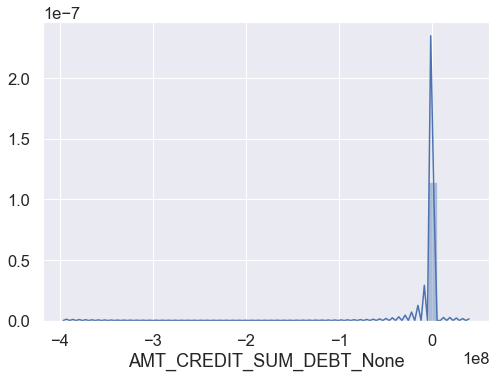

In [26]:
bureau['AMT_CREDIT_SUM_DEBT_None'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
sns.distplot(bureau['AMT_CREDIT_SUM_DEBT_None'])

In [27]:
group = bureau.groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM_DEBT_None':'sum'}).reset_index()
train = train.merge(group, on='SK_ID_CURR', how='left')
test = test.merge(group, on='SK_ID_CURR', how='left')

### AMT_CREDIT/AMT_GOODS_PRICE

In [28]:
train = train.merge(application_train[['AMT_GOODS_PRICE', 'SK_ID_CURR']], on='SK_ID_CURR', how='left')
test = test.merge(application_test[['AMT_GOODS_PRICE', 'SK_ID_CURR']], on='SK_ID_CURR', how='left')
train['AMT_CREDIT/AMT_GOODS_PRICE'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
test['AMT_CREDIT/AMT_GOODS_PRICE'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']

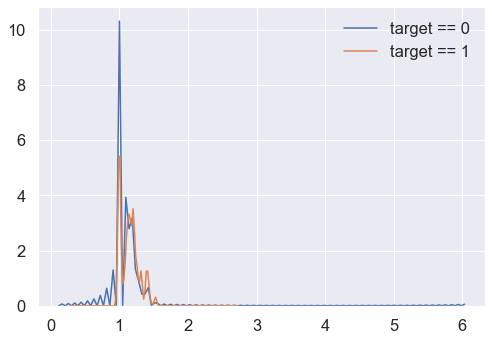

In [29]:
sns.kdeplot(train.loc[train['TARGET'] == 0, 'AMT_CREDIT/AMT_GOODS_PRICE'], label = 'target == 0')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'AMT_CREDIT/AMT_GOODS_PRICE'], label = 'target == 1')

### AMT_GOODS_PRICE - AMT_CREDIT

In [30]:
train['AMT_GOODS_PRICE - AMT_CREDIT'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
test['AMT_GOODS_PRICE - AMT_CREDIT'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']

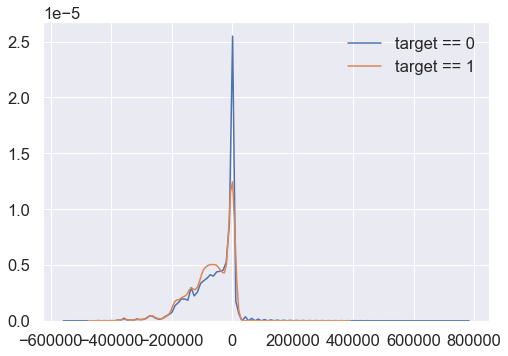

In [31]:
sns.kdeplot(train.loc[train['TARGET'] == 0, 'AMT_GOODS_PRICE - AMT_CREDIT'], label = 'target == 0')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'AMT_GOODS_PRICE - AMT_CREDIT'], label = 'target == 1')

### annuity_to_max_installment_ratio

In [32]:
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500000,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500000,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.433594,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500000,NaN


In [33]:
installments_payments.query('SK_ID_CURR == 161674')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
44807,2452854,161674,1.0,21,-546.0,-552.0,11302.605469,11302.605469
47438,1054186,161674,1.0,2,-1300.0,-1307.0,6948.359863,6948.359863
66454,1682318,161674,1.0,2,-240.0,-243.0,7374.509766,7374.509766
87379,2452854,161674,1.0,10,-876.0,-882.0,11302.605469,11302.605469
138614,1054186,161674,1.0,8,-1120.0,-1175.0,6948.359863,6948.359863
216905,1054186,161674,1.0,12,-1000.0,-1033.0,6935.220215,6935.220215
247928,2452854,161674,1.0,20,-576.0,-578.0,11302.605469,11302.605469
284969,1644291,161674,1.0,11,-140.0,-144.0,22048.560547,22048.560547
425089,1054186,161674,1.0,3,-1270.0,-1275.0,6948.359863,6948.359863


In [34]:
group = installments_payments.groupby('SK_ID_CURR').agg({'AMT_INSTALMENT':'max'}).reset_index()
train = train.merge(group, on='SK_ID_CURR', how='left')
test = test.merge(group, on='SK_ID_CURR', how='left')

### AGE_INT

In [35]:
train['AGE_INT'] = round(train['DAYS_BIRTH'] / -365)
test['AGE_INT'] = round(test['DAYS_BIRTH'] / -365)

# この辺りを入れていったんLGBM

In [36]:
train_df = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
train_y = train['TARGET']
test_df = test.drop('SK_ID_CURR', axis=1)

In [37]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            maxdepth=4,
            num_leaves=13,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 10)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[220]	training's auc: 0.82313	training's binary_logloss: 0.223663	valid_1's auc: 0.791097	valid_1's binary_logloss: 0.235808
  score Train : 0.823130   score Valid : 0.791097
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[193]	training's auc: 0.819062	training's binary_logloss: 0.225271	valid_1's auc: 0.795647	valid_1's binary_logloss: 0.234482
  score Train : 0.819062   score Valid : 0.795647
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[214]	training's auc: 0.822198	training's binary_logloss: 0.223758	valid_1's auc: 0.791957	valid_1's binary_logloss: 0.235717
  score Train : 0.822198   score Valid : 0.791957
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[240]	training's auc: 0.826224	training's binary_logloss: 0.222153	valid_1's auc: 0.79004

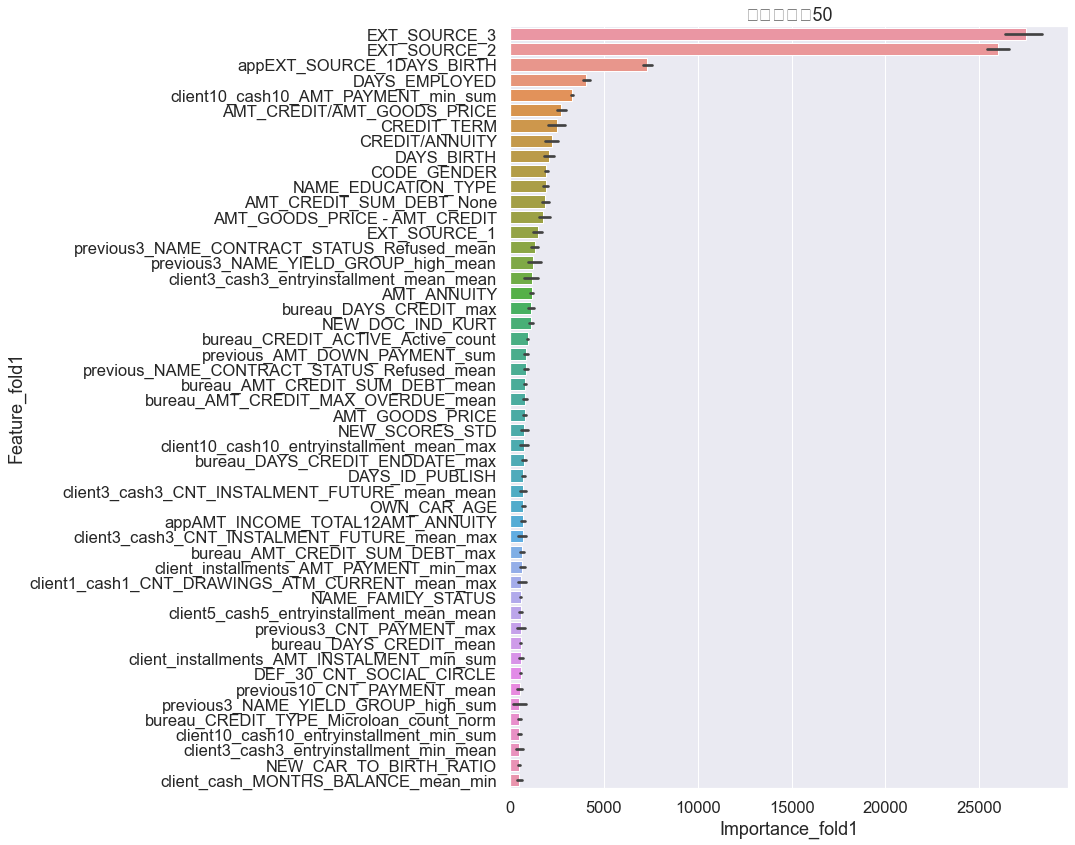

In [38]:
indices = feature_importance_plot(feat_df)

In [39]:
indices

,Feature_fold1,Importance_fold1
21,EXT_SOURCE_3,27463.797379
20,EXT_SOURCE_2,26002.601603
44,appEXT_SOURCE_1DAYS_BIRTH,7286.078704
14,DAYS_EMPLOYED,4045.111193
95,client10_cash10_AMT_PAYMENT_min_sum,3308.072859
3,AMT_CREDIT/AMT_GOODS_PRICE,2727.768974
12,CREDIT_TERM,2483.480799
11,CREDIT/ANNUITY,2213.073292
13,DAYS_BIRTH,2048.248141
10,CODE_GENDER,1924.330559


# 前に効いてたEXT_SOURCE系を入れる

In [40]:
train['EXT_SOURCE_mean'] = (train['EXT_SOURCE_3'] +train['EXT_SOURCE_2'] +train['EXT_SOURCE_1']) / 3
test['EXT_SOURCE_mean'] = (test['EXT_SOURCE_3'] +test['EXT_SOURCE_2'] +test['EXT_SOURCE_1']) / 3

train['EXT_SOURCE_cal'] = train['EXT_SOURCE_3']*train['EXT_SOURCE_2']*train['EXT_SOURCE_1']
test['EXT_SOURCE_cal'] = test['EXT_SOURCE_3']*test['EXT_SOURCE_2']*test['EXT_SOURCE_1']

train['EXT_SOURCE_weight_mean'] = (train['EXT_SOURCE_3']*3 +train['EXT_SOURCE_2']*2 +train['EXT_SOURCE_1'])/3
test['EXT_SOURCE_weight_mean'] = (test['EXT_SOURCE_3']*3 +test['EXT_SOURCE_2']*2 +test['EXT_SOURCE_1']) / 3

# ついでに加重平均も入れてみた

In [41]:
train_df = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
train_y = train['TARGET']
test_df = test.drop('SK_ID_CURR', axis=1)

In [42]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            maxdepth=4,
            num_leaves=13,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 10)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[238]	training's auc: 0.825239	training's binary_logloss: 0.222766	valid_1's auc: 0.792238	valid_1's binary_logloss: 0.235406
  score Train : 0.825239   score Valid : 0.792238
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[213]	training's auc: 0.8216	training's binary_logloss: 0.224231	valid_1's auc: 0.796233	valid_1's binary_logloss: 0.234113
  score Train : 0.821600   score Valid : 0.796233
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[197]	training's auc: 0.820454	training's binary_logloss: 0.22458	valid_1's auc: 0.791025	valid_1's binary_logloss: 0.236163
  score Train : 0.820454   score Valid : 0.791025
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[254]	training's auc: 0.828235	training's binary_logloss: 0.221376	valid_1's auc: 0.790687	

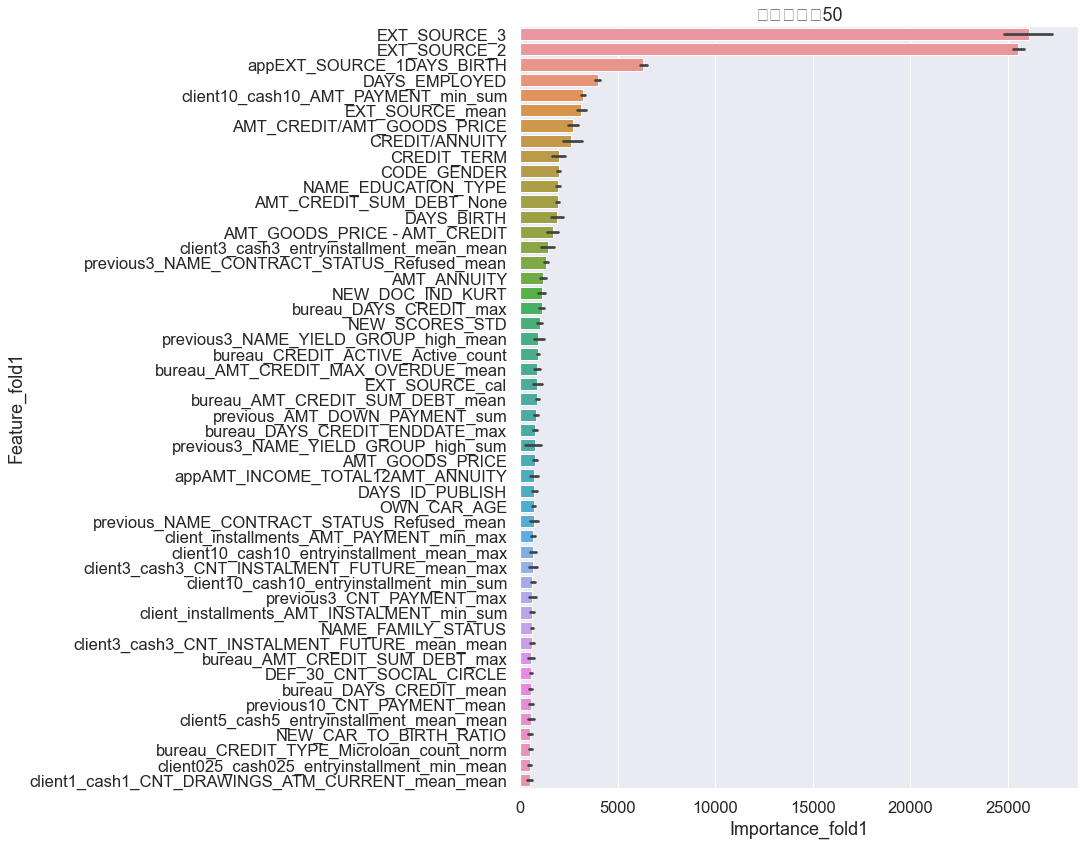

In [43]:
indices = feature_importance_plot(feat_df)

In [44]:
indices

,Feature_fold1,Importance_fold1
21,EXT_SOURCE_3,26077.673555
20,EXT_SOURCE_2,25538.342400
47,appEXT_SOURCE_1DAYS_BIRTH,6306.746418
14,DAYS_EMPLOYED,3962.081236
98,client10_cash10_AMT_PAYMENT_min_sum,3193.389339
23,EXT_SOURCE_mean,3127.819111
3,AMT_CREDIT/AMT_GOODS_PRICE,2719.127204
11,CREDIT/ANNUITY,2615.537818
12,CREDIT_TERM,1997.406993
10,CODE_GENDER,1963.688374


In [45]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)
# 0.79641 #0.78971

# user_image

In [21]:
user_image = pd.read_excel('../home credit/user_100006_image.xlsx')
user_image

,SK_ID_CURR,var_name,-96,-95,-94,-93,-92,-91,-90,-89,-88,-87,-86,-85,-84,-83,-82,-81,-80,-79,-78,-77,-76,-75,-74,-73,-72,-71,-70,-69,-68,-67,-66,-65,-64,-63,-62,-61,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
0,100006,AMT_ANNUITY_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0
1,100006,AMT_ANNUITY_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2482.920000,0.0,0.0,0.00,0.00,0.00,39954.510000,0.000,0.0,0.0,29027.520000,0.00,0.00,0.00,0.00,7.044210e+04,0.00,0.00,0.00,0.00,0.00,0.0
2,100006,AMT_APPLICATION_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26912.340000,0.0,0.0,0.00,0.00,0.00,454500.000000,0.000,0.0,0.0,334917.000000,0.00,0.00,0.00,0.00,1.633500e+06,0.00,0.00,0.00,0.00,0.00,0.0
3,100006,AMT_BALANCE_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0
4,100006,AMT_CREDIT_LIMIT_ACTUAL_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,2.700000e+05,270000.00,270000.00,270000.00,270000.00,270000.00,0.0
5,100006,AMT_CREDIT_SUM_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.000000,0.000,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0
6,100006,AMT_CREDIT_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24219.000000,0.0,0.0,0.00,0.00,0.00,481495.500000,0.000,0.0,0.0,267930.000000,0.00,0.00,0.00,0.00,1.851615e+06,0.00,0.00,0.00,0.00,0.00,0.0
7,100006,AMT_DOWN_PAYMENT_sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2693.340000,0.0,0.0,0.00,0.00,0.0